In [ ]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
 
class myDataset(Dataset):
    def __init__(self, data_dir, segment_len=128):
        self.data_dir = data_dir
        self.segment_len = segment_len
 
    # Load the mapping from speaker neme to their corresponding id. 
        mapping_path = Path(data_dir) / "mapping.json"
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping["speaker2id"]
 
    # Load metadata of training data.
        metadata_path = Path(data_dir) / "metadata.json"
        metadata = json.load(open(metadata_path))["speakers"]
 
    # Get the total number of speaker.
        self.speaker_num = len(metadata.keys())
        self.data = []
        for speaker in metadata.keys():
            for utterances in metadata[speaker]:
                self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, index):
        feat_path, speaker = self.data[index]
    # Load preprocessed mel-spectrogram.
        mel = torch.load(os.path.join(self.data_dir, feat_path))
 
    # Segmemt mel-spectrogram into "segment_len" frames.
        if len(mel) > self.segment_len:
      # Randomly get the starting point of the segment.
            start = random.randint(0, len(mel) - self.segment_len)
      # Get a segment with "segment_len" frames.
            mel = torch.FloatTensor(mel[start:start+self.segment_len])
        else:
            mel = torch.FloatTensor(mel)
    # Turn the speaker id into long for computing loss later.
        speaker = torch.FloatTensor([speaker]).long()
        return mel, speaker
    
    def get_speaker_number(self):
        return self.speaker_num

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
  # Process features within a batch.
 
    mel, speaker = zip(*batch)
  # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
  # mel: (batch size, length, 40)
    return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
    
    dataset = myDataset(data_dir)
    speaker_num = dataset.get_speaker_number()
  # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
  )
    
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
  )
    print("train_set:",len(trainset),"valid_set:",len(validset))
    return train_loader, valid_loader, speaker_num


train_loader,valid_loader,speaker_num=get_dataloader("/kaggle/input/dataset2/Dataset",32,2)
print("speaker_num:",speaker_num)
# trainloader shape:[32,128,40]

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange
from einops.layers.torch import Rearrange

class Swish(nn.Module):
    def forward(self, x):
        return x * x.sigmoid()

class ConformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff=nn.Sequential(
            nn.Linear(80,320),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(320,80),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.atten=nn.TransformerEncoderLayer(
      d_model=80, dim_feedforward=256, nhead=1
    ) 
        self.conv=nn.Sequential(
            nn.LayerNorm(80),
            Rearrange('b n c -> b c n'),
            nn.Conv1d(80,160,1,1),
            nn.GLU(dim=1),
            Rearrange('b c n -> b n c'),
            nn.Conv1d(128,128,1,1),
            Rearrange('b n c -> b c n'),
            Swish(),
            nn.Conv1d(80,80,1,1),
            Rearrange('b c n -> b n c'),
            nn.Dropout(p=0.1)
        )
        self.norm = nn.LayerNorm(80)
    def forward(self,x):
        x=0.5*self.ff(x)+x
        x=self.atten(x).transpose(0, 1)+x.transpose(0, 1)
        x=self.conv(x)+x
        x=0.5*self.ff(x)+x
        x=self.norm(x)
        return x
    
class Classifier(nn.Module):
    def __init__(self, d_model=80, n_spks=600, dropout=0.1):
        super().__init__()
    # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)
    # TODO:
    #   Change Transformer to Conformer.
    #   https://arxiv.org/abs/2005.08100
        self.encoder_layer = nn.TransformerEncoderLayer(
      d_model=d_model, dim_feedforward=256, nhead=1
    )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.conformer=ConformerBlock()
    # Project the the dimension of features from d_model into speaker nums.
        self.pred_layer = nn.Sequential(
      #nn.Linear(d_model, d_model),
      #nn.ReLU(),
      nn.Linear(d_model, n_spks),
    )

    def forward(self, mels):
   
    # out: (batch size, length, d_model)
        out = self.prenet(mels)
    # out: (length, batch size, d_model)
        out = out.permute(1, 0, 2)
    # The encoder layer expect features in the shape of (length, batch size, d_model).
        out = self.conformer(out)
    # out: (batch size, length, d_model)
        
        stats = out.mean(dim=1)

    # out: (batch, n_spks)
        out = self.pred_layer(stats)
        return out

In [34]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
        optimizer: Optimizer,
        num_warmup_steps: int,
        num_training_steps: int,
        num_cycles: float = 0.5,
        last_epoch: int = -1
):
    def lr_lambda(current_step):
        # warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)


In [35]:
import torch


def model_fn(batch, model, criterion, device):
  
    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)

    outs = model(mels)

    loss = criterion(outs, labels)

  # Get the speaker id with highest probability.
    preds = outs.argmax(1)
  # Compute accuracy.
    accuracy = torch.mean((preds == labels).float())

    return loss, accuracy

from tqdm import tqdm
import torch
def valid(dataloader, model, criterion, device): 
  

    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
   
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss, accuracy = model_fn(batch, model, criterion, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()

    model.train()

    return running_accuracy / len(dataloader)

[Info]: Use cuda now!
train_set: 62494 valid_set: 6944
[Info]: Finish loading data!
[Info]: Finish creating model!
1 /100,train_acc: 0.04265625
val_acc: 0.10555875576036866
2 /100,train_acc: 0.1755
val_acc: 0.2436635944700461
3 /100,train_acc: 0.2845625
val_acc: 0.3201324884792627
4 /100,train_acc: 0.34125
val_acc: 0.388536866359447
5 /100,train_acc: 0.39421875
val_acc: 0.4099942396313364
6 /100,train_acc: 0.4295625
val_acc: 0.44772465437788017
7 /100,train_acc: 0.4550625
val_acc: 0.46327764976958524
8 /100,train_acc: 0.48328125
val_acc: 0.4870391705069124
9 /100,train_acc: 0.50475
val_acc: 0.5
10 /100,train_acc: 0.516875
val_acc: 0.5252016129032258
11 /100,train_acc: 0.53609375
val_acc: 0.536434331797235
12 /100,train_acc: 0.551625
val_acc: 0.5429147465437788
13 /100,train_acc: 0.56503125
val_acc: 0.5652361751152074
14 /100,train_acc: 0.578375
val_acc: 0.5734447004608295
15 /100,train_acc: 0.5874375
val_acc: 0.5891417050691244
16 /100,train_acc: 0.59696875
val_acc: 0.5859735023041475


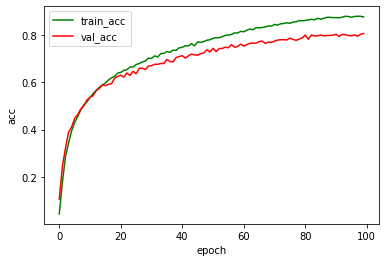

In [45]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


def parse_args():
    config = {
    "data_dir": "/kaggle/input/dataset2/Dataset",
    "save_path": "model.ckpt",
    "batch_size": 32,
    "n_workers": 8,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 100001,
  }

    return config

train_acc_list=[]
val_acc_list=[]

def main(
  data_dir,
  save_path,
  batch_size,
  n_workers,
  valid_steps,
  warmup_steps,
  total_steps,
  save_steps,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    model = Classifier(n_spks=speaker_num).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_accuracy = -1.0
    best_state_dict = None

    
    batch_accuracy=0.0
    for step in range(total_steps):
    # Get data
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss, accuracy = model_fn(batch, model, criterion, device)
        batch_loss = loss.item()
        batch_accuracy += accuracy.item()
        if(step%1000==0 and step!=0 ):
            batch_accuracy/=1000
            print(int(step/1000),"/100,train_acc:",batch_accuracy)
            train_acc_list.append(batch_accuracy)
            batch_accuracy=0
            
        
    # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    
        
    # Do validation
        if step  % 1000 == 0 and step!=0 :
            valid_accuracy = valid(valid_loader, model, criterion, device)
            print("val_acc:",valid_accuracy)
            val_acc_list.append(valid_accuracy)
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()

            
    # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
    plt.figure()
    x=range(0,100)
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.plot(x,train_acc_list,color='g',label='train_acc')
    plt.plot(x,val_acc_list,color='r',label='val_acc')
    plt.legend()
    plt.show()
if __name__ == "__main__":
    main(**parse_args())